# Pre-processing and synchronizing ephys data: an example notebook

The objective of this notebook is to be able to take all the output files that are generated by the ephys setup and Ronan cottage and synchronizing all of them to the same clock.

We are using session S20230323 from BRAC4779.2a [HELMET], the first session we recorded. 

## Running list of things ot improve on

- As a small note, we have to re-write the bonsai workflow to record the cameras in the arena in a convincing way, so that it inherits the name from the stimulus workflow ideally, like in Yiran's case. Work on that. 
- The outputs should all go to the same recording folder if they're part of the same recording. Like in Yiran's case. 
- We want to save the raw output from the chip, so we will have to find a way to remap it later, I guess. 


In [1]:
from pathlib import Path
import cottage_analysis.io_module.onix as onix
import cottage_analysis.io_module.harp as harp
from matplotlib import pyplot as plt
import numpy as np

session = Path('/camp/lab/znamenskiyp/data/instruments/raw_data/projects/blota_onix_pilote/BRAC7449.2a/S20230323')

/camp/lab/znamenskiyp/home/users/colasa/.conda/envs/cottage_analysis/lib/python3.11/site-packages/pyparsing/core.py:23: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants


## Which files were outputted this time?

- Three different folders and some loose files 
    - Outputs of the AcquireEphys
    - Outputs of stimulus
    - Outputs of HF cameras
    - Outputs of FM cameras

In [2]:
ephys = session / 'R115806'
stimulus = session / 'R115817_SpheresPermTubeReward'
headfixed_cam = session / 'R115821_BRAC7449.2a'

## Importing the ephys outputs (rhd2164)

Ephys outputs start with rhd2164, which is the intan digital electrophysiology interface chip on the headstage. There are three files created, one is aux, one is clock, one is ephys and one is first_time. 

Antonin wrote a function which takes them all together and makes a memmap object with them, so that they can be easily accessed. 

In [3]:
processed_ephys = onix.load_rhd2164(ephys)
processed_ephys

{'first_time': '2023-03-23T11:58:06.1912960+00:00',
 'clock': memmap([        1890,        10210,        18512, ..., 511840213096,
         511840221417, 511840229720], dtype=uint64),
 'ephys': memmap([[ 9586,  9370,  9332, ..., 32705, 32675, 32674],
         [13307, 13004, 12731, ..., 32759, 32791, 32861],
         [10940, 10663, 10583, ..., 32828, 32741, 32781],
         ...,
         [10953, 10742, 10602, ..., 32614, 32658, 32678],
         [15063, 14717, 14392, ..., 32656, 32684, 32764],
         [13215, 13023, 13003, ..., 32701, 32637, 32764]], dtype=uint16),
 'aux': memmap([[56956, 58838, 56956, ..., 58314,   621, 54549],
         [16288, 16288, 16288, ..., 16291, 16292, 16291],
         [45446, 41682, 40427, ..., 62281, 63849, 61967],
         [16300, 16300, 16300, ..., 16306, 16306, 16306],
         [24727, 32536, 32536, ..., 18874, 18874, 18874],
         [15943, 15942, 15942, ..., 15937, 15937, 15937]], dtype=uint16),
 'hubsynccounter': memmap([    1079872,     1081272,     1

Let's attempt to read the ephys outputs!

import matplotlib.pyplot as plt 
import numpy as np
import os
import spikeinterface.extractors as se
import pickle
import pandas as pd
import spikeinterface as si

num_channels = 64
sampling_frequency = 30000
gain_to_uV = 0.195
offset_to_uV = -2**15*gain_to_uV
dtype="uint16"#This could be sensitive: our chip writes in uint16, had to change to int16 for kilosort (?)
time_axis = 0

path_to_openephys = '/camp/lab/znamenskiyp/data/instruments/raw_data/projects/blota_onix_pilote/BRAC7449.2a/S20230323/R115806/rhd2164-ephys_2023-03-23T11_58_06.raw'

recording = si.read_binary(path_to_openephys, num_chan=num_channels, sampling_frequency=sampling_frequency,
                            dtype=dtype, gain_to_uV=gain_to_uV, offset_to_uV=offset_to_uV,
                            time_axis=time_axis)



import spikeinterface.widgets as sw

#trace_snippet = recording.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))
#print('Traces shape:', trace_snippet.shape)

import scipy.signal
from spikeinterface.preprocessing import (bandpass_filter, notch_filter, common_reference,
                                          remove_artifacts, preprocesser_dict)
recording_bp = bandpass_filter(recording, freq_min=200, freq_max=10000)

recording_cmr = common_reference(recording_bp, reference='global', operator='median')


channel_ids = range(30, 40)
channel_ids

w_ts = sw.plot_timeseries(recording_cmr, channel_ids=channel_ids, time_range=(2000.8, 2001), return_scaled=True)

## Loading lighthouse data (ts4231)

Three different lighthouse-generated files, one per diode. ts4231 is the name of the photodiode

In [4]:
processed_photodiode = onix.load_ts4231(ephys)
processed_photodiode

{2:                                timestamp         clock         x         y  \
 0      2023-03-23T11:58:06.3336448+00:00      17844015  0.251915  0.108775   
 1      2023-03-23T11:58:06.3885312+00:00      26158154  0.251847  0.108646   
 2      2023-03-23T11:58:06.4301184+00:00      34467086  0.251878  0.108721   
 3      2023-03-23T11:58:06.4851584+00:00      42781198  0.251843  0.108702   
 4      2023-03-23T11:58:06.5358080+00:00      51100646  0.251835  0.108745   
 ...                                  ...           ...       ...       ...   
 29571  2023-03-23T12:32:18.6834560+00:00  511796018303  0.219194  0.179626   
 29572  2023-03-23T12:32:18.7276160+00:00  511812558322  0.212413  0.175876   
 29573  2023-03-23T12:32:18.7530240+00:00  511820872517  0.208419  0.174579   
 29574  2023-03-23T12:32:18.7766784+00:00  511829181399  0.204346  0.173979   
 29575  2023-03-23T12:32:18.7981952+00:00  511837495612  0.200559  0.173492   
 
               z  
 0     -0.678530  
 1     -0

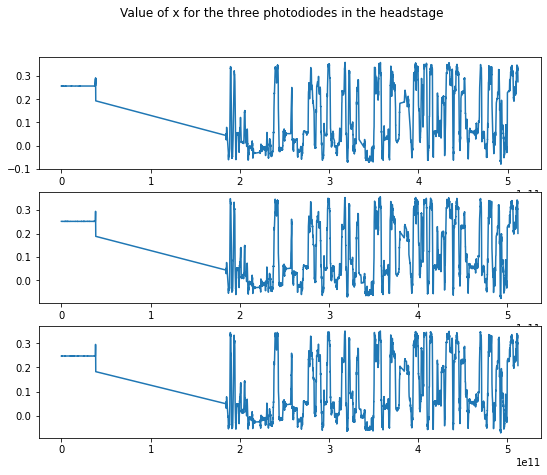

In [5]:
fig, axs = plt.subplots(3, 1, figsize = (9, 7))

fig.suptitle('Value of x for the three photodiodes in the headstage')
axs[0].plot(processed_photodiode[1]['clock'], processed_photodiode[1]['x'])
axs[1].plot(processed_photodiode[2]['clock'], processed_photodiode[2]['x'])
axs[2].plot(processed_photodiode[3]['clock'], processed_photodiode[3]['x'])


## Loading IMU data (bno055)

We have nothing to load the IMU data. Should I write it? Wrote it on onix. 

In [6]:
processed_bno = onix.load_bno055(ephys)
processed_bno.keys()

quaternion = processed_bno['quaternion']
quaternion = quaternion/2**14
linear = processed_bno['linear']
linear = linear / 100
euler = processed_bno['euler']
euler = euler / 16
gravity = processed_bno['gravity']
gravity = gravity / 100

Let's see how they look. Wrong, they look wrong. 

In [24]:
minutes = len(linear[:,1])/100/60

print(f'The recording was {minutes} s in length')

The recording was 34.1825 s in length


Text(0.5, 1.0, 'Gravity vector')

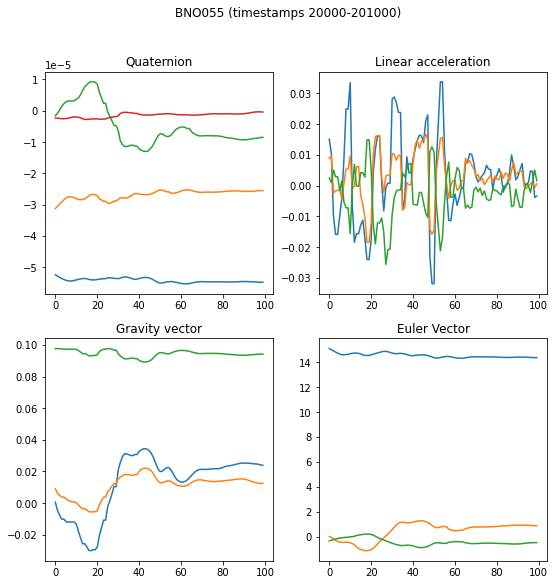

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))

fig.suptitle('BNO055 (timestamps 20000-201000)')

timeslice=range(170000, 170100)

axs[0, 0].plot(quaternion[timeslice, 3])
axs[0, 0].plot(quaternion[timeslice, 0])
axs[0, 0].plot(quaternion[timeslice, 1])
axs[0, 0].plot(quaternion[timeslice, 2])
axs[0, 0].set_title('Quaternion')

axs[0, 1].plot(linear[timeslice, 0])
axs[0, 1].plot(linear[timeslice, 1])
axs[0, 1].plot(linear[timeslice, 2])
axs[0, 1].set_title('Linear acceleration')

axs[1, 1].plot(euler[timeslice, 0])
axs[1, 1].plot(euler[timeslice, 1])
axs[1, 1].plot(euler[timeslice, 2])
axs[1, 1].set_title('Euler Vector')

axs[1, 0].plot(gravity[timeslice, 0])
axs[1, 0].plot(gravity[timeslice, 1])
axs[1, 0].plot(gravity[timeslice, 2])
axs[1, 0].set_title('Gravity vector')

And extract the heading from this

In [39]:
from math import atan2

fq0=quaternion[:,0]
fq1=quaternion[:,1]
fq2=quaternion[:,2]
fq3=quaternion[:,3]
heading = np.zeros(len(fq0))
#heading[sample] = [atan2((2*(quaternion[0]*quaternion[3]+quaternion[1]*quaternion[2])), (1-2*(quaternion[2]**2+quaternion[3]**2))) for sample in quaternion[0]]

for i in range(len(fq0)):
    q0, q1, q2, q3 = fq0[i], fq1[i], fq2[i], fq3[i]
    heading[i]=atan2((2*(q0*q3+q1*q2)), (1-2*(q2**2+q3**2)))



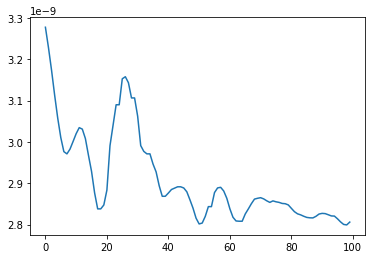

In [41]:
plt.plot(heading[timeslice])


## Loading the stimulus logs and synchronizing them to the ephys clock

## Loading the freely moving cameras and synchronizing them to the ephys clock

## Loading the head-fixed cameras and synchronizing them to the ephys clock